In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src')
from CellType_PSY import *
import scanpy as sc
HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol = LoadGeneINFO()

/home/jw3514/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Preprocessing

In [5]:
def Z1Conversion(ExpMat, outname="test.z1.mat"):
    Z_mat = []
    for g, row in ExpMat.iterrows():
        tmp = ZscoreConverting(row.values)
        Z_mat.append(tmp)
    Z_mat = np.array(Z_mat)
    CT_Z1_DF = pd.DataFrame(data=Z_mat, index=ExpMat.index.values, 
                            columns=ExpMat.columns.values)
    CT_Z1_DF.to_csv(outname)
    return CT_Z1_DF

## Cell Type

In [69]:
MedianDF = pd.read_csv("dat/SC_UMI_Mats/cluster_MeanLogUMI.csv", index_col=0)
MedianDF_Z1 = Z1Conversion(MedianDF, "dat/SC_UMI_Mats/cluster_V3_Z1Mat.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [13]:
max_Z, min_Z = 5, -5
MedianDF_Z1_clipped = MedianDF_Z1.clip(upper=max_Z, lower=min_Z)
MedianDF_Z1_clipped.to_csv("dat/SC_UMI_Mats/cluster_V3_Z1Mat.clip.csv")

In [70]:
max_Z, min_Z = 3, -3
MedianDF_Z1_clipped3 = MedianDF_Z1.clip(upper=max_Z, lower=min_Z)
MedianDF_Z1_clipped3.to_csv("dat/SC_UMI_Mats/cluster_V3_Z1Mat.clip3.csv")

In [20]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/ClusterV3_UMI_ISHMatch_Z2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/SC_UMI_Mats//Cluster_Z2Mat_ISHMatch.csv")

In [3]:
# Combine Zclip3
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/ClusterV3_UMI_ISHMatch_z1cplip3_Z2//"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/SC_UMI_Mats//Cluster_Z2Mat_ISHMatch.z1clip3.csv")

In [15]:
Z2_Z1clip5 = pd.read_csv("dat/SC_UMI_Mats//Cluster_Z2Mat_ISHMatch.csv", index_col=0)
Z2_Z1clip3 = pd.read_csv("dat/SC_UMI_Mats//Cluster_Z2Mat_ISHMatch.z1clip3.csv", index_col=0)

In [16]:
genes = Z2_Z1clip3.index.values

In [17]:
Z2_Z1clip5.head(2)

,0001 CLA-EPd-CTX Car3 Glut_1,0002 CLA-EPd-CTX Car3 Glut_1,0003 CLA-EPd-CTX Car3 Glut_1,0004 CLA-EPd-CTX Car3 Glut_1,0005 CLA-EPd-CTX Car3 Glut_2,0006 IT EP-CLA Glut_1,0007 IT EP-CLA Glut_1,0008 IT EP-CLA Glut_1,0009 IT EP-CLA Glut_1,0010 IT EP-CLA Glut_1,...,5313 BAM NN_1,5314 BAM NN_1,5315 Monocytes NN_1,5316 DC NN_1,5317 DC NN_1,5318 DC NN_1,5319 B cells NN_1,5320 ILC NN_2,5321 NK cells NN_3,5322 T cells NN_4
4026,-1.368285,-1.985172,-2.605926,-1.580151,-1.491348,-2.700678,-2.749591,-1.651863,-1.789041,-2.095699,...,0.036018,0.056495,-0.501134,-0.098495,0.648926,0.223753,0.344987,-0.245598,0.007265,-0.088779
285386,-0.451323,-0.551024,-0.133967,-0.337516,-0.203270,-0.513539,-0.385356,0.138846,-0.708439,-0.434136,...,0.171248,0.122395,0.275833,-0.113096,-0.082444,0.005902,0.195109,0.256879,0.105698,0.163597


In [18]:
ct = "0001 CLA-EPd-CTX Car3 Glut_1"
X = Z2_Z1clip5.loc[genes, ct]
Y = Z2_Z1clip3.loc[genes, ct]

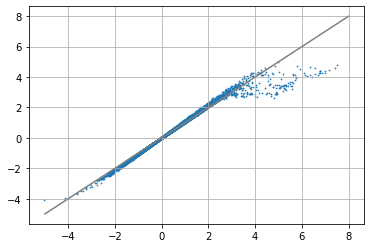

In [22]:
plt.scatter(X,Y,s=0.5)
plt.plot([-5,8], [-5, 8], color="grey")
plt.grid(True)

<AxesSubplot: xlabel='0001 CLA-EPd-CTX Car3 Glut_1', ylabel='Density'>

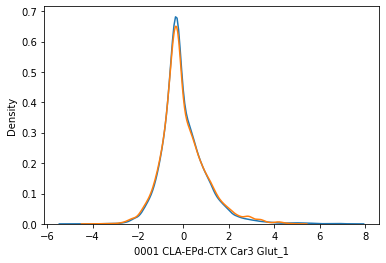

In [20]:
sns.kdeplot(X)
sns.kdeplot(Y)

##### Test Check Z1 cal

In [33]:
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/scripts')
from script_Z2_calculation import *

In [41]:
class fakeargs:
    def __init__(self, Z1mat, matchDIR):
        self.input = Z1mat
        self.match = matchDIR
        self.start = 1
        self.step = 1
        self.outdir = ""

In [42]:
Z1mat = "dat/SC_UMI_Mats/cluster_V3_Z1Mat.clip.csv"
matchDIR = "/home/jw3514/Work/ASD_Circuits/dat/genes/ExpMatch_RootExp_uniform_kernal/"

In [43]:
args = fakeargs(Z1mat, matchDIR)
ins = script_Z2_calculation(args)

In [44]:
entrez=1
match_genes = loadgenelist(ins.matchDir+"/{}.csv".format(entrez), toint=True)
match_genes = [int(g) for g in match_genes if g in ins.z1_mat.index.values]
match_genes = match_genes[:1000]

In [58]:
STR = "0494 OB Eomes Ms4a15 Glut_4"
gene = entrez
z_gene = ins.z1_mat.loc[gene, STR]
z_matches = [ins.z1_mat.loc[g, STR] for g in match_genes]
z_matches2 = [x for x in z_matches if x == x]
b = (z_gene - np.mean(z_matches2)) / np.std(z_matches2)

In [59]:
print(len(match_genes), len(z_matches), len(z_matches2))

1000 1000 987


In [61]:
z_matches22 = [(g,x) for (g,x) in zip(match_genes, z_matches) if x == x]

In [65]:
with open("Entrez_1_CT_0494_MatchZ1.txt", "wt") as f:
    for g,z in z_matches22:
        f.write("{},{}\n".format(g,z))

In [49]:
print(b)

5.262477384884109


In [52]:
print(z_gene)
print(np.mean(z_matches), np.std(z_matches))

5.0
0.0025883036216507124 0.9496310066306163


In [53]:
print(len(z_matches))

987


In [57]:
np.nan == np.nan

False

## MERFISH

In [8]:
def quantile_normalize(df):
    ranks = df.rank(method='min', na_option='keep')
    sorted_df = np.sort(df.values, axis=0)
    nan_mask = np.isnan(df.values)
    sorted_df[nan_mask] = 0
    means = np.nanmean(np.where(nan_mask, np.nan, sorted_df), axis=1)
    means[np.isnan(sorted_df).all(axis=1)] = np.nan
    rank_mean_dict = {rank: mean for rank, mean in zip(np.arange(1, len(means)+1), means)}
    normalized_df = ranks.applymap(lambda x: rank_mean_dict.get(x, np.nan))

    return normalized_df

In [6]:
MERFISH_STRAnn = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/MERFISH.ISH_Annot.csv", index_col=0)

/tmp/ipykernel_42829/3316840270.py:1: DtypeWarning: Columns (2,3,8,9,10,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  MERFISH_STRAnn = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/MERFISH.ISH_Annot.csv", index_col=0)


In [13]:
## Annotate EXP: script_STR_SC_ExpMat.py

In [4]:
MERFISH_CellMeanExp = pd.read_csv("dat/MERFISH/STR_Cell_Mean_DF.UMI.csv", index_col=0)
MERFISH_VolMeanExp = pd.read_csv("dat/MERFISH/STR_Vol_Mean_DF.UMI.csv", index_col=0)

In [6]:
MERFISH_CellMean_Z1 = Z1Conversion(MERFISH_CellMeanExp, "dat/MERFISH/STR_Cell_Mean_Z1Mat.csv")
MERFISH_VolMean_Z1 = Z1Conversion(MERFISH_VolMeanExp, "dat/MERFISH/STR_Vol_Mean_Z1Mat.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std
/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [7]:
max_Z, min_Z = 5, -5
DF_Z1_clipped = MERFISH_CellMean_Z1.clip(upper=max_Z, lower=min_Z)
DF_Z1_clipped.to_csv("dat/MERFISH/STR_Cell_Mean_Z1Mat.clip.csv")

max_Z, min_Z = 5, -5
DF_Z1_clipped = MERFISH_VolMean_Z1.clip(upper=max_Z, lower=min_Z)
DF_Z1_clipped.to_csv( "dat/MERFISH/STR_Vol_Mean_Z1Mat.clip.csv")

In [9]:
MERFISH_VolMeanExp_EXP_QN = quantile_normalize(MERFISH_VolMeanExp)
MERFISH_VolMeanExp_QN_Z1 = Z1Conversion(MERFISH_VolMeanExp_EXP_QN, "dat/MERFISH/STR_Vol_Mean_QNZ1Mat.csv")

In [16]:
MERFISH_CellMeanExp = pd.read_csv("dat/MERFISH_Zhuang/STR_Cell_Mean_DF.UMI.csv", index_col=0)
MERFISH_VolMeanExp = pd.read_csv("dat/MERFISH_Zhuang/STR_Vol_Mean_DF.UMI.csv", index_col=0)

In [17]:
MERFISH_CellMean_Z1 = Z1Conversion(MERFISH_CellMeanExp, "dat/MERFISH_Zhuang/STR_Cell_Mean_Z1Mat.csv")
MERFISH_VolMean_Z1 = Z1Conversion(MERFISH_VolMeanExp, "dat/MERFISH_Zhuang/STR_Vol_Mean_Z1Mat.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std
/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [18]:
max_Z, min_Z = 5, -5
DF_Z1_clipped = MERFISH_CellMean_Z1.clip(upper=max_Z, lower=min_Z)
DF_Z1_clipped.to_csv("dat/MERFISH_Zhuang/STR_Cell_Mean_Z1Mat.clip.csv")

max_Z, min_Z = 5, -5
DF_Z1_clipped = MERFISH_VolMean_Z1.clip(upper=max_Z, lower=min_Z)
DF_Z1_clipped.to_csv( "dat/MERFISH_Zhuang/STR_Vol_Mean_Z1Mat.clip.csv")

In [4]:
MERFISH_NEU_MeanExp = pd.read_csv("dat/MERFISH/STR_NEU_Mean_DF.UMI.csv", index_col=0)

In [7]:
MERFISH_NEU_Z1 = Z1Conversion(MERFISH_NEU_MeanExp, "dat/MERFISH/STR_NEU_Mean_Z1Mat.csv")
max_Z, min_Z = 5, -5
DF_Z1_clipped = MERFISH_NEU_Z1.clip(upper=max_Z, lower=min_Z)
DF_Z1_clipped.to_csv("dat/MERFISH/STR_NEU_Mean_Z1Mat.clip.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [12]:
MERFISH_NEU_Vol_MeanExp = pd.read_csv("dat/MERFISH/STR_NEU_Vol_Mean_DF.UMI.csv", index_col=0)
MERFISH_NEU_Vol_Z1 = Z1Conversion(MERFISH_NEU_Vol_MeanExp, "dat/MERFISH/STR_NEU_Vol_Mean_Z1Mat.csv")
max_Z, min_Z = 5, -5
DF_Z1_clipped = MERFISH_NEU_Vol_Z1.clip(upper=max_Z, lower=min_Z)
DF_Z1_clipped.to_csv("dat/MERFISH/STR_NEU_Vol_Mean_Z1Mat.clip.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [13]:
MERFISH_NEU_Vol_MeanExp.head(2)

,Frontal pole cerebral cortex,Primary motor area,Secondary motor area,Primary somatosensory area nose,Primary somatosensory area barrel field,Primary somatosensory area lower limb,Primary somatosensory area mouth,Primary somatosensory area upper limb,Primary somatosensory area trunk,Supplemental somatosensory area,...,Pyramus VIII,Nodulus X,Simple lobule,Ansiform lobule,Paramedian lobule,Paraflocculus,Flocculus,Fastigial nucleus,Interposed nucleus,Dentate nucleus
114786,0.007287,0.017782,0.016941,0.019084,0.021972,0.020816,0.021806,0.019340,0.014409,0.018819,...,0.005552,0.014220,0.016265,0.010392,0.006234,0.009139,0.012645,0.004848,0.005195,0.008882
6101,0.000023,0.000054,0.000054,0.000052,0.000061,0.000061,0.000063,0.000056,0.000043,0.000058,...,0.000021,0.000066,0.000072,0.000042,0.000024,0.000038,0.000052,0.000016,0.000025,0.000042


In [11]:
MERFISH_CellMeanExp_EXP_QN = quantile_normalize(MERFISH_CellMeanExp)
MERFISH_CellMeanExp_QN_Z1 = Z1Conversion(MERFISH_CellMeanExp_EXP_QN, "dat/MERFISH/STR_Cell_Mean_QNZ1Mat.csv")

/home/jw3514/Work/CellType_Psy/src/ASD_Circuits.py:70: RuntimeWarning: invalid value encountered in double_scalars
  z = (x - mean)/std


In [15]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Allen_CellMean_UMI_ISHMatch_Z2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH/STR_Cell_Mean_Z2Mat_ISHMatch.csv")

Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Allen_VolMean_UMI_ISHMatch_Z2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH/STR_Vol_Mean_Z2Mat_ISHMatch.csv")

In [8]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Allen_NEU_Mean_UMI_ISHMatch_Z2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH/STR_NEUR_Mean_Z2Mat_ISHMatch.csv")

In [14]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_Allen_NEU_Vol_Mean_UMI_ISHMatch_Z2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH/STR_NEUR_Vol_Mean_Z2Mat_ISHMatch.csv")

In [19]:
Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_MIT_CellMean_UMI_ISHMatch_Z2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Zhuang/STR_Cell_Mean_Z2Mat_ISHMatch.csv")

Z2_split_dir = "/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/Z2.Split/MERFISH_MIT_VolMean_UMI_ISHMatch_Z2/"
DFs = []
for file in os.listdir(Z2_split_dir):
    df = pd.read_csv(Z2_split_dir + file, index_col = 0)
    DFs.append(df)
Z2_MAt = pd.concat(DFs)
Z2_MAt.to_csv("dat/MERFISH_Zhuang/STR_Vol_Mean_Z2Mat_ISHMatch.csv")

#### Experssion Matching Based on MERFISH

In [3]:
MERFISH_STRAnn = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/MERFISH.ISH_Annot.csv", index_col=0)

/tmp/ipykernel_163938/3316840270.py:1: DtypeWarning: Columns (2,3,8,9,10,21,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  MERFISH_STRAnn = pd.read_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/MERFISH/MERFISH.ISH_Annot.csv", index_col=0)


In [4]:
ClusterExpDF = pd.read_csv("dat/SC_UMI_Mats/cluster_MeanLogUMI.csv", index_col=0)

In [10]:
Total_Exp_Genes = np.zeros(ClusterExpDF.shape[0])
for c, row in MERFISH_STRAnn.iterrows():
    cluster = row["cluster"]
    if cluster in ClusterExpDF.columns.values:
        exp = ClusterExpDF[cluster]
        Total_Exp_Genes += exp

In [15]:
Total_Exp_Genes.index

Int64Index([   114786,      6101,     64321,     29088,     10434,      6917,
                 8601,     51606,      4986,      2831,
            ...
            107075310,      4509,      4508,      4514,      4537,      4539,
                 4538,      4540,      4541,      4519],
           dtype='int64', length=17938)

In [27]:
WB_ExpDF = pd.DataFrame(Total_Exp_Genes)
WB_ExpDF.columns=["TotalExp"]

In [30]:
WB_ExpDF = WB_ExpDF.sort_values("TotalExp")
WB_ExpDF["Rank"] = [1+x for x in range(WB_ExpDF.shape[0])] # compute Rank
WB_ExpDF["quantile"] = WB_ExpDF["Rank"]/WB_ExpDF.shape[0]
WB_ExpDF.to_csv("MouseMERFISHGeneMatchQuantile.csv")

In [31]:
WB_ExpDF

,TotalExp,Rank,quantile
2657,0.000000e+00,1,0.000056
83897,0.000000e+00,2,0.000111
337972,0.000000e+00,3,0.000167
8926,0.000000e+00,4,0.000223
474381,0.000000e+00,5,0.000279
...,...,...,...
4512,2.320334e+07,17934,0.999777
107075310,2.328927e+07,17935,0.999833
4513,2.328927e+07,17936,0.999889
4514,2.361706e+07,17937,0.999944
